# Sentiment Classifier 
Code borrowed from Robyn Speer's post, "[How to make a racist AI without really trying](http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/)."

In [362]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import re
import statsmodels.formula.api
from scipy import stats

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [253]:
# Configure how graphs will show up in this notebook
%matplotlib inline
seaborn.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)
seaborn.set_style("dark")


### Word Embeddings

We'll use the debiased embeddings from [ConceptNet Numberbatch](https://github.com/commonsense/conceptnet-numberbatch) which was in turn based on Bolukbasi et al.'s ["Debiasing Word Embeddings"](https://arxiv.org/abs/1607.06520).

In [3]:
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')



In [5]:
embeddings = load_embeddings('./sentiment_data/numberbatch-en-17.06.txt')
embeddings.shape

(417194, 300)

#### You can retrain to use different word embeddings

In [6]:
# use this to retrain with different word embeddings

def retrain_model(new_embs):
    """
    Repeat the steps above with a new set of word embeddings.
    """
    global model, embeddings, name_sentiments
    embeddings = new_embs
    pos_vectors = embeddings.loc[pos_words].dropna()
    neg_vectors = embeddings.loc[neg_words].dropna()
    vectors = pd.concat([pos_vectors, neg_vectors])
    targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
    labels = list(pos_vectors.index) + list(neg_vectors.index)

    train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
        train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
        
    model = SGDClassifier(loss='log', random_state=0, max_iter=500)
    model.fit(train_vectors, train_targets)
    
    accuracy = accuracy_score(model.predict(test_vectors), test_targets)
    print("Accuracy of sentiment: {:.2%}".format(accuracy))
    
    name_sentiments = name_sentiment_table()
    ols_model = statsmodels.formula.api.ols('sentiment ~ group', data=name_sentiments).fit()
    print("F-value of bias: {:.3f}".format(ols_model.fvalue))
    print("Probability given null hypothesis: {:.3}".format(ols_model.f_pvalue))
    
    # Show the results on a swarm plot, with a consistent Y-axis
    plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)
    plot.set_ylim([-10, 10])

In [7]:
# retrain_model(embeddings)

## Lexicon
Sentiment lexicon to do our training against. From [Hu and Liu, 2004](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon).

In [8]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('./sentiment_data/positive-words.txt')
neg_words = load_lexicon('./sentiment_data/negative-words.txt')

## Train model to predict word sentiments

In [9]:
#words not in the embedding vocabulary are dropped.

pos_vectors = embeddings.loc[pos_words].dropna()
neg_vectors = embeddings.loc[neg_words].dropna()

In [390]:
# how many positive/negative words do we have?
print(len(pos_vectors), 'positive words')
print(len(neg_vectors), 'negative words')

1821 positive words
4461 negative words


In [10]:
# make arrays of inputs (embeddings) and outputs (1 for positive word, -1 for negative)
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [11]:
#use SKLearn train_test_split to split data
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [12]:
model = SGDClassifier(loss='log', random_state=0, max_iter=500)
model.fit(train_vectors, train_targets)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=500,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=0, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [13]:
accuracy_score(model.predict(test_vectors), test_targets)

0.972972972972973

Result: Our model correctly predicts word sentiment for test data 97% of the time.

In [14]:
#show examples of sentiment predictions

def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


# Show 20 examples from the test set
words_to_sentiment(test_labels).ix[:20]

,sentiment
doomsday,-3.114388
jealous,-2.358464
fell,-3.792117
volatile,-3.661624
demoralizing,-6.486617
chilly,-2.522120
dead,-2.896550
wildly,-3.409500
escapade,-1.355828
disappointingly,-3.503244


## Sentiment scores for text
We'll average word sentiments to get sentiment for text passages. Averaging (rather than summing) sentiments normalizes for sentence length, as short sentences might have very extreme values. This simple method also doesn't take into account negation. Apostrophes/possessives are also not addressed with this method. 

In [15]:
import re
TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.

def text_to_sentiment(text):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    sentiments = words_to_sentiment(tokens)
    return sentiments['sentiment'].mean()

In [16]:
#examples
print("this example is pretty cool >>","sentiment score:", text_to_sentiment("this example is pretty cool"))
print("this example is okay >>","sentiment score:", text_to_sentiment("this example is okay"))
print("meh, this example sucks >>","sentiment score:", text_to_sentiment("meh, this sample sucks"))

this example is pretty cool >> sentiment score: 1.6224625446915817
this example is okay >> sentiment score: 0.6583007382158219
meh, this example sucks >> sentiment score: -1.557344372324323


## Sentiment analysis of BERT summaries

### Some minor data preprocessing
First we need to load our model's inputs and outputs. We'll put them all in one dataframe, then clean it up for use in our sentiment analyzer. This should be pretty easy, since our model is very simple, and our data has already been processed either for/by the summary generator.

In [20]:
#load BERT outputs - abstractive summaries
val_1500 = pd.read_csv('../w266-project-v2/PreSumm/val_1500_output_raw.txt', sep='\n', names=['summary'])
val_3800 = pd.read_csv('../w266-project-v2/PreSumm/val_3800_output_raw.txt', sep='\n', names=['summary'])
output_data = pd.concat([val_1500, val_3800], ignore_index=True)

#load BERT inputs - full articles
inputs_1500 = pd.read_csv('mini_val_articles_clean_no_separators.csv', sep='\n', names=['article'])
inputs_3800 = pd.read_csv('mini_val2_no_sep.csv', sep='\n', names=['article'])
input_data = pd.concat([inputs_1500, inputs_3800], ignore_index=True)

In [21]:
bert_data = input_data.join(output_data)
bert_data.head()

,article,summary
0,"0,""Sally Forrest, an actress-dancer who graced...","forrest , whose birth name was katherine feene..."
1,"1,""A middle-school teacher in China has inked ...","wang lian , 35 , has created 1000 stunning ink..."
2,"2,""A man convicted of killing the father and s...","iftekhar murtaza, 30, was sentenced to death t..."
3,"3,""Avid rugby fan Prince Harry could barely wa...",england beat france 55-35 in 'le crunch match ...
4,"4,""A Triple M Radio producer has been inundate...",after tuesday 's grill team show- hosts matty ...


We can see remnants of reading our file in from CSV in our input articles. We'll get rid of the unused index and extra punctuation around each example. Also, we'll make all characters lowercase. We'll leave numbers as is, since the sentiment model will read those as unknowns, so they won't count in determining sentiment. The BERT outputs have `"<q>"` as their sentence separators so we'll remove those as well.

In [22]:
#remove the first 3 and last character of each string
def remove_b(example):
    return example[3:-1]

In [23]:
# run REMOVE_B once only
bert_data['article'] = bert_data['article'].apply(remove_b)
# lower-case the inputs
bert_data['article'] = bert_data['article'].apply(str.lower)
# replace sentence separators
bert_data['summary'].replace("<q>",". ",regex=True,inplace=True)

bert_data.head()

,article,summary
0,"sally forrest, an actress-dancer who graced th...","forrest , whose birth name was katherine feene..."
1,a middle-school teacher in china has inked hun...,"wang lian , 35 , has created 1000 stunning ink..."
2,a man convicted of killing the father and sist...,"iftekhar murtaza, 30, was sentenced to death t..."
3,avid rugby fan prince harry could barely watch...,england beat france 55-35 in 'le crunch match ...
4,a triple m radio producer has been inundated w...,after tuesday 's grill team show- hosts matty ...


In [24]:
# with open('BERT_inputs_outputs.csv', 'w') as f1:
#     bert_data.to_csv(f1)

### Checking that our data works with our sentiment analyzer

In [25]:
#check a summary
text = bert_data.iloc[0,1]
text

'forrest , whose birth name was katherine feeney , was 86 and had long battled cancer. she was a protege of hollywood trailblazer ida lupino who cast her in starring roles in films including the critical and commercial success not wanted'

In [26]:
#examine tokens extracted
tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
tokens[:10]

['forrest',
 'whose',
 'birth',
 'name',
 'was',
 'katherine',
 'feeney',
 'was',
 '86',
 'and']

In [27]:
#examine individual sentiments for the tokens
words_to_sentiment(tokens)[:10]

,sentiment
forrest,0.049555
whose,-0.754028
birth,-0.139973
name,0.440332
was,-1.277489
katherine,-1.864752
feeney,-1.097092
was,-1.277489
and,0.877879
had,-2.098260


In [28]:
text_to_sentiment(text)

-0.22505097215787953

### Analysis
We've checked that our sentiment analyzer should work with our data. Let's do some analysis.

In [29]:
import re
TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.

def text_to_sentiment(text):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    sentiments = words_to_sentiment(tokens)
    return sentiments['sentiment'].mean()

In [31]:
# This cell takes about a minute to run on our 5300 examples
bert_data['article_sentiment'] = bert_data['article'].apply(text_to_sentiment)
bert_data['summary_sentiment'] = bert_data['summary'].apply(text_to_sentiment)

In [32]:
pd.set_option('max_colwidth',40)
bert_data.head()

,article,summary,article_sentiment,summary_sentiment
0,"sally forrest, an actress-dancer who...","forrest , whose birth name was kathe...",-0.368003,-0.225051
1,a middle-school teacher in china has...,"wang lian , 35 , has created 1000 st...",-0.073772,0.093536
2,a man convicted of killing the fathe...,"iftekhar murtaza, 30, was sentenced ...",-0.863705,-1.026023
3,avid rugby fan prince harry could ba...,england beat france 55-35 in 'le cru...,-0.033666,-0.168233
4,a triple m radio producer has been i...,after tuesday 's grill team show- ho...,-0.584158,-0.709280


In [33]:
# bert_data[{'article_sentiment','summary_sentiment'}]

### Here we've plotted the article and summary sentiments.

In [34]:
# seaborn.set(style="darkgrid")
# fig, ax = plt.subplots(figsize=(10,10))
# seaborn.regplot(x='article_sentiment', y='summary_sentiment', data=bert_data)

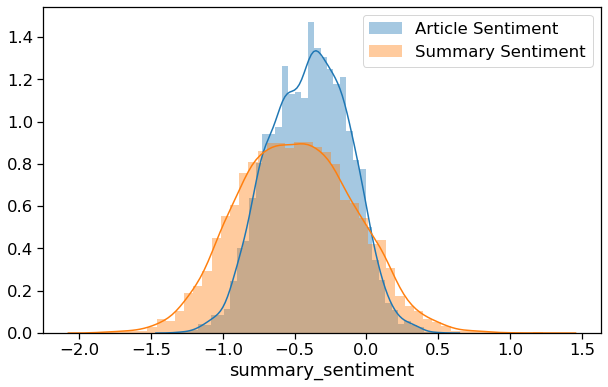

In [35]:
plt.subplots(figsize=(10,6))
seaborn.distplot(bert_data['article_sentiment'], label='Article Sentiment')
seaborn.distplot(bert_data['summary_sentiment'], label='Summary Sentiment')
plt.legend()

Interestingly, it looks like summaries tend to be less neutral than the articles, and maybe slightly more negative. Both articles and summaries on average appear to be more negative than positive. This may be due to the average news article being a negative story and/or a bias in our model toward negative classification. 

We're interested in how an individual summary compares to its original article. Let's take the difference in sentiment scores for each example and examine those.

In [227]:
bert_data['sentiment_difference'] = bert_data['summary_sentiment'] - bert_data['article_sentiment']

#gives outliers - outside of 2.5% and 97.5%
outliers_limit = (stats.scoreatpercentile(bert_data['sentiment_difference'], per=[2.5, 97.5]))

bert_data['is_sent_diff_outlier'] = np.where((bert_data['sentiment_difference'] <= outliers_limit[0]) | (bert_data['sentiment_difference'] >= outliers_limit[1]), 1, 0)
bert_data.head()

,article,summary,article_sentiment,summary_sentiment,sentiment_difference,is_sent_diff_outlier,fem_count,art_fem_count,art_masc_count,art_fem_diff,sum_fem_count,sum_masc_count,sum_fem_diff
0,"sally forrest, an actress-dancer who graced the silver screen throughout the '40s and '50s in mgm musicals and films such as the 1956 noir while the city sleeps died on march 15 at her home in beverly hills, california. forrest, whose birth name was katherine feeney, was 86 and had long battled cancer. her publicist, judith goffin, announced the news thursday. scroll down for video . actress: sally forrest was in the 1951 ida lupino-directed film 'hard, fast and beautiful' (left) and the 1956 fritz lang movie 'while the city sleeps' a san diego native, forrest became a protege of hollywood trailblazer ida lupino, who cast her in starring roles in films including the critical and commercial success not wanted, never fear and hard, fast and beautiful. some of forrest's other film credits included bannerline, son of sinbad, and excuse my dust, according to her imdb\xc2\xa0page. the page also indicates forrest was in multiple climax! and rawhide television episodes. forrest appeared as herself in an episode of the ed sullivan show and three episodes of the dinah shore chevy show, her imdb page says. she also starred in a broadway production of the seven year itch. city news service reported that other stage credits included as you like it, no, no, nanette and damn yankees. forrest married writer-producer milo frank in 1951. he died in 2004. she is survived by her niece, sharon durham, and nephews, michael and mark feeney. career: a san diego native, forrest became a protege of hollywood trailblazer ida lupino, who cast her in starring roles in films .","forrest , whose birth name was katherine feeney , was 86 and had long battled cancer. she was a protege of hollywood trailblazer ida lupino who cast her in starring roles in films including the critical and commercial success not wanted",-0.368003,-0.225051,0.142952,0,NaN,2.0,0.0,2.0,2.0,0.0,2.0
1,"a middle-school teacher in china has inked hundreds of sketches that are beyond be-leaf. politics teacher wang lian, 35, has created 1000 stunning ink drawings covering subjects as varied as cartoon characters and landscapes to animals, birds according to\xc2\xa0the\xc2\xa0people's daily online. the intricate scribbles on leaves feature wang's favourite sites across the city of nanjing, which include the presidential palace, yangtze river bridge, the ancient jiming temple and the qinhuai river. natural canvas: artist and teacher wang lian has done hundreds of drawings, like this temple, on leaves she collects in the park and on the streets . delicate: she uses an ink pen to gently draw the local scenes and buildings on the dried out leaves . 'although teaching politics is my job, drawing is my passion and hobby,' said wang. 'i first tried drawing on leaves about 10 years ago and fell in love with it as an art form immediately. 'it's like drawing on very old parchment paper, you have to be really careful that you don't damage the leaf because it is very fragile and this helps focus your attention and abilities.' wang started giving the drawings away on\xc2\xa0christmas eve in 2012 when her junior high school son came home saying he wanted to prepare some gifts for his classmates. being an avid painter, wang decided to give her son's friends unique presents of gingko leaf paintings. wang loves gingko leaves and will often pick them up along gingko avenue, near to her school, in nanjing in east china's jiangsu province. every autumn she collects about 2,000 leaves from the ground to ensure she has enough to cover spoils too. intricate: teacher wang has drawn hundreds of local scenes on leaves she has collected from the park . hobby: the artist collects leaves every autumn and dries them out so she can sketch these impressive building scenes . 'the colour and shape of gingko leaves are particularly beau

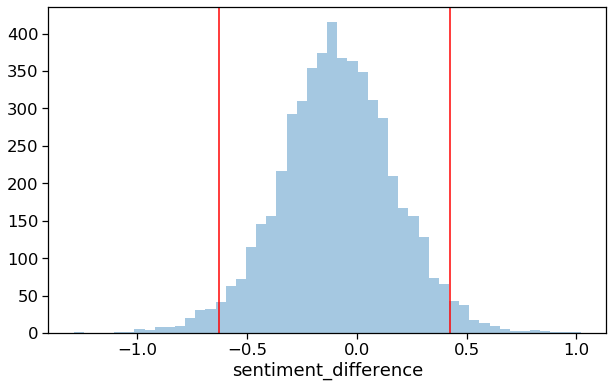

In [37]:
plt.subplots(figsize=(10,6))
seaborn.distplot(bert_data['sentiment_difference'], kde=False)

plt.axvline(outliers_limit[0],0,1, color='red')
plt.axvline(outliers_limit[1],0,1, color = 'red')

The mean of the difference in sentiments looks just about centered at 0. The two red lines indicate where the 2.5th and 97.5th percentiles of the data are outliers. These are examples for which the sentiment scores for the article and the summary are highly different.

5 example outliers
1. Soccer article about possible redemption from a season of errors. Summary is good,
2. Pretty technical article about vaccine. Summary is bad. sentiment model says summary is very negative, but it's not
3. story about a failed kidnapping. summary is bad, sounds positive.
4. bad summary about homeless population. sentiment analyzer also bad. maybe a vocabulary issue
5.


In [44]:
pd.set_option('display.max_colwidth', -1)
some_outliers = bert_data.iloc[np.where(bert_data['is_sent_diff_outlier'] == 1)]
some_outliers[-5:]


article  \
5251  1,"roberto martinez has branded everton\xe2\x80\x99s current position in the barclays premier league \xe2\x80\x98unacceptable\xe2\x80\x99 but he has no intention of sacrificing their european dream. everton have slithered onto the fringes of the relegation fight after only winning one league game in 2015 and they face crucial fixtures against newcastle and queens park rangers before the international break. martinez accepts his position will be the subject of intense focus until results improve but he is refusing to panic. roberto martinez put his players through their paces during a training session on wednesday . martinez checks his watch as time runs out to prepare his side for the clash against dynamo kiev . everton boss martinez faced the media at finch farm ahead of the europa league clash at goodison . the manager is confident a big performance against dynamo kiev, coached by former tottenham striker sergei rebrov, on thursday night will be the catalyst for a sustained improvement over the final 10 games of the domestic campaign. martinez said: \xe2\x80\x98i know the severity of the situation and about not having margin for error. i have been brought up with it. i don\xe2\x80\x99t think that is a problem. for us as a football club, the position we are in is unacceptable. \xe2\x80\x98at the end of the season, we need to look at why it has happened. but for the time being, we need to show a real desire to win. steven naismith (centre) shares a joke during an everton training session exercise on wednesday . the everton squad work hard in training ahead of facing dynamo kiev in the europa league last 16 . loanee aaron lennon jogs around the pitches as everton prepare for europa league action . he added: \xe2\x80\x98i don\xe2\x80\x99t look to blame anyone. football is a game of errors and the responsibility is mine. i will always accept that. i am not going to change now. the team is performing in a manner that we should have got more points. but the reality is we have got 28 points. now every game is a final.\xe2\x80\x99 everton have been formidable in europe this season and have won five of their eight matches and martinez said: \xe2\x80\x98in the europa league, i think we have had an opportunity to show what we can do. 'we have played top teams but we have gone eye-to-eye with them. in the premier league, everything that could go wrong, goes wrong.\xe2\x80\x99                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [39]:
most_positive_outlier = bert_data.iloc[bert_data['sentiment_difference'].idxmax()]
most_positive_outlier

article                 7,"(cnn)want to take a self-portrait using your snazzy new selfie stick in front of london\'s national gallery? that\'s fine. but don\'t try to use it inside the museum. the national gallery has become the latest museum to ban the handy (or irritating, depending on your point of view) device. selfies turn museums into playgrounds for a day . the british museum joins the smithsonian, new york\'s museum of modern art and a host of institutions around the world banning what the new york museum calls ""camera extension poles."" before you pout that the ban is going to ruin your selfie for #museumselfie day next year, know that mar dixon, the day\'s creator, supports the ban. ""i\'m all for photos in museums as that is a memory -- a personal memory -- of your visit,"" dixon wrote in an email. but not selfie sticks, which she says allow you to invade other people\'s personal space. ""they\'re just as bad imo as tripods or opening an umbrella. ""there is also a risk, w

In [40]:
most_negative_outlier = bert_data.iloc[bert_data['sentiment_difference'].idxmin()]
most_negative_outlier

article                 8,"a mother and her daughter who both have a rare condition which makes their skin wrinkle prematurely have undergone matching \xc2\xa350,000 facelifts. tracey gibson, 45, \xc2\xa0and her daughter zara hartshorn, 18, both suffer lipodystrophy, a rare condition which makes fat dissolve beneath tissue. while zara had a face-lift at the age of 16 to stave off bullies, her mother has long suffered lingering stares and cruel nicknames. having been rejected by the nhs for a free operation, the mother of seven thought she would be forever trapped in a sinking face. but, two years since her daughter received free surgery from american doctors, the 45-year-old has unveiled her new \xc2\xa350,000 face after being flown overseas to receive the same vip treatment. scroll down for video . zara hartshorn, 18, \xc2\xa0and her mother tracey gibson, 45, (above) have undergone matching \xc2\xa350,000 facelifts abroad after suffering a lifetime of taunts over their wrinkled skin .

In [41]:
stats.describe(bert_data['is_sent_diff_outlier'])

DescribeResult(nobs=5300, minmax=(0, 1), mean=0.050188679245283016, variance=0.04767877171556043, skewness=4.1203947278663, kurtosis=14.977652713428391)

## Analysis of Sentiment Based on Gendered Inputs
I want to know if our BERT-based news article summarizer has a bias in the sentiment of the summaries it writes, based on whether the article is about a male or female subject.

To do this, we need to classify the articles into female- or male-subject articles. First, we use SKLearn's CountVectorizer to create sparse matrices of our text inputs/outputs. Then, we'll count the number of times gendered pronouns (he/him/his, she/her/hers) appear in each text input or output. Finally, we'll create a metric using these counts to classify articles. More on that below.

In [42]:
# train CountVectorizer -- teaching it the vocabulary of our set of articles and set of summaries
from sklearn.feature_extraction.text import CountVectorizer
cv_art = CountVectorizer(min_df = 0.0, strip_accents = 'unicode', max_df = 1.0, ngram_range=(1,1))
cv_sum = CountVectorizer(min_df = 0.0, strip_accents = 'unicode', max_df = 1.0, ngram_range=(1,1))

cv_art.fit(bert_data['article'])
cv_sum.fit(bert_data['summary'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [231]:
# transform our text passages into sparse matrices, basically turning into counts of words
art_vec = cv_art.transform(bert_data['article'])
sum_vec = cv_sum.transform(bert_data['summary'])

# code below was a check to see that it works on the entire corpus

# art_vocab = art_vec.sum(axis=0)
# sum_vocab = sum_vec.sum(axis=0)

# art_vocab_freq = [(word, art_vocab[0, idx]) for word, idx in cv_art.vocabulary_.items()]
# sum_vocab_freq = [(word, sum_vocab[0, idx]) for word, idx in cv_sum.vocabulary_.items()]

# art_freq_df = pd.DataFrame(list(sorted(art_vocab_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','count'])
# sum_freq_df = pd.DataFrame(list(sorted(sum_vocab_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','count'])

In [240]:
# Create functions to do gendered pronoun counts. 
# I KNOW it's slow, but I did this in a day, and I'm no software engineer.
# commented out initializing the new columns because it was erasing data?

def genderize_articles(a,b):
#     bert_data['art_fem_count'] = np.nan
#     bert_data['art_masc_count'] = np.nan
#     bert_data['art_fem_diff'] = np.nan
    
    for nn in range(a,b):
        summed_wordcount = art_vec[nn].sum(axis=0)
        freq = [(word, summed_wordcount[0, idx]) for word, idx in cv_art.vocabulary_.items()]
        freq = pd.DataFrame(freq, columns = ['word','count'])
        fem_count = sum([int(freq.loc[freq['word']=='her']['count']) + int(freq.loc[freq['word']=='hers']['count']) + int(freq.loc[freq['word']=='she']['count'])])
        masc_count = sum([int(freq.loc[freq['word']=='him']['count']) + int(freq.loc[freq['word']=='his']['count']) + int(freq.loc[freq['word']=='he']['count'])])
        fem_diff = fem_count - masc_count
        bert_data['art_fem_count'][nn] = fem_count
        bert_data['art_masc_count'][nn] = masc_count
        bert_data['art_fem_diff'][nn] = fem_count - masc_count
    return(bert_data[{'sum_fem_count','sum_masc_count','sum_fem_diff', 'art_fem_count', 'art_masc_count', 'art_fem_diff'}].iloc[a:b])
    
def genderize_summaries(a,b):
#     bert_data['sum_fem_count'] = np.nan
#     bert_data['sum_masc_count'] = np.nan
#     bert_data['sum_fem_diff'] = np.nan

    for nn in range(a,b):
        summed_wordcount = sum_vec[nn].sum(axis=0)
        freq = [(word, summed_wordcount[0, idx]) for word, idx in cv_sum.vocabulary_.items()]
        freq = pd.DataFrame(freq, columns = ['word','count'])
        fem_count = sum([int(freq.loc[freq['word']=='her']['count']) + int(freq.loc[freq['word']=='she']['count']) ])
        masc_count = sum([int(freq.loc[freq['word']=='him']['count']) + int(freq.loc[freq['word']=='his']['count']) + int(freq.loc[freq['word']=='he']['count']) ])
        fem_diff = fem_count - masc_count
        bert_data['sum_fem_count'][nn] = fem_count
        bert_data['sum_masc_count'][nn] = masc_count
        bert_data['sum_fem_diff'][nn] = fem_count - masc_count
        
    return(bert_data[{'sum_fem_count','sum_masc_count','sum_fem_diff', 'art_fem_count', 'art_masc_count', 'art_fem_diff'}].iloc[a:b])


In [241]:
# This takes forever. Something like 10-20 min to do the 5300 examples we have.

# genderize_articles(1,10)
# genderize_summaries(1,50)

,art_masc_count,art_fem_count,art_fem_diff,sum_masc_count,sum_fem_diff,sum_fem_count
1,2.0,20.0,18.0,0.0,1.0,1.0
2,16.0,17.0,1.0,2.0,1.0,3.0
3,13.0,0.0,-13.0,0.0,0.0,0.0
4,12.0,2.0,-10.0,1.0,0.0,1.0
5,16.0,0.0,-16.0,2.0,-2.0,0.0
6,1.0,14.0,13.0,0.0,0.0,0.0
7,0.0,18.0,18.0,0.0,9.0,9.0
8,0.0,22.0,22.0,0.0,1.0,1.0
9,8.0,0.0,-8.0,1.0,-1.0,0.0


### "Gender Coefficient" of a text passage: 
The count of female pronouns minus the count of male pronouns divided by the total count of pronouns. Gender Coefficient closer to 1.0 indicates only women were mentioned, while Gender Coefficient closer to -1.0 indicates only men were mentioned. 

Of course, if no gender pronouns were mentioned, we get NaN for the Gender Coefficient. That's okay, because we're only interested in text we can easily tell is gendered.

In [353]:
bert_data['art_gender_coeff'] = bert_data['art_fem_diff']/(bert_data['art_masc_count'] + bert_data['art_fem_count'])
bert_data['sum_gender_coeff'] = bert_data['sum_fem_diff']/(bert_data['sum_masc_count'] + bert_data['sum_fem_count'])
bert_data[{'sum_fem_count','sum_masc_count','sum_fem_diff', 'art_fem_count', 'art_masc_count', 'art_fem_diff', 'art_gender_coeff', 'sum_gender_coeff'}].head(10)


,art_masc_count,art_fem_count,art_fem_diff,art_gender_coeff,sum_gender_coeff,sum_masc_count,sum_fem_diff,sum_fem_count
0,0.0,2.0,2.0,1.000000,1.0,0.0,2.0,2.0
1,2.0,20.0,18.0,0.818182,1.0,0.0,1.0,1.0
2,16.0,17.0,1.0,0.030303,0.2,2.0,1.0,3.0
3,13.0,0.0,-13.0,-1.000000,NaN,0.0,0.0,0.0
4,12.0,2.0,-10.0,-0.714286,0.0,1.0,0.0,1.0
5,16.0,0.0,-16.0,-1.000000,-1.0,2.0,-2.0,0.0
6,1.0,14.0,13.0,0.866667,NaN,0.0,0.0,0.0
7,0.0,18.0,18.0,1.000000,1.0,0.0,9.0,9.0
8,0.0,22.0,22.0,1.000000,1.0,0.0,1.0,1.0
9,8.0,0.0,-8.0,-1.000000,-1.0,1.0,-1.0,0.0


Quick examination of the distribution of Gender Coefficients reveals that most examples are written exclusively about either men or women. Also, our dataset consists of more than twice as many news articles about men exclusively than about women exclusively. We also see that the counts of gender coefficients match up pretty much exactly between the articles and summaries -- an indication that the BERT summarizer is doing its job well.

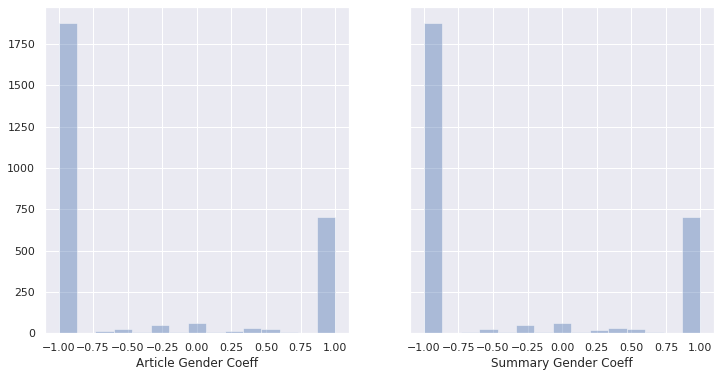

In [268]:
seaborn.set()
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,6))

seaborn.distplot(bert_data['art_gender_coeff'], kde=False, bins = 15, axlabel='Article Gender Coeff', ax=ax1)
seaborn.distplot(bert_data['sum_gender_coeff'], kde=False, bins = 15, axlabel='Summary Gender Coeff', ax=ax2)

I want to use the examples that are all-male or all-female for sentiment analysis. We can avoid ambiguously gendered articles, and in any case, most or our examples are exclusively a single gender. 

Let's follow up with a sanity check on our data. Here I'm checking that the gender coefficient is preserved after summarization. We can see that we only have 1 deviation per gender group.

In [391]:
#do summaries keep the same gender coefficient as their corresponding article?
print('female-subject articles count:', bert_data['article'].loc[bert_data['art_gender_coeff']==1].count())
print('female-subject summaries count:', bert_data['article'].loc[bert_data['sum_gender_coeff']==1].count())
print('number in agreement:', bert_data['article'].loc[(bert_data['art_gender_coeff']==1) & (bert_data['sum_gender_coeff']==1)].count())

print('\nmale-subject articles count:', bert_data['article'].loc[bert_data['art_gender_coeff']==-1].count())
print('male-subject summaries count:', bert_data['article'].loc[bert_data['sum_gender_coeff']==-1].count())
print('number in agreement:', bert_data['article'].loc[(bert_data['art_gender_coeff']==-1) & (bert_data['sum_gender_coeff']==-1)].count())


female-subject articles count: 704
female-subject summaries count: 705
number in agreement: 704

male-subject articles count: 1879
male-subject summaries count: 1878
number in agreement: 1878


### On to sentiment analysis, with gender
The next thing we'll do is compare the sentiment analysis scores for the articles and summaries, but now we're going to do this for examples whose pronouns are exclusively male or exclusively female.

We're going to ignore the initial article sentiment scores in favor of examining the difference in sentiment scores between pairs of articles and summaries. There are multiple reasons for this. The first is that we know we cannot trust our original sample of news articles to be written to treat men and women the same -- we've already seen that there are far more articles about men than women. Second, we cannot trust our sentiment analysis model to be unbiased in its classification with regard to gender. The original purpose of this sentiment model was, in fact, to point out that the data that models are trained on have a direct effect on models' biases. 

However, by comparing the difference in sentiment scores between article/summary pairs rather than the absolute scores, we can attenuate these concerns since the thing that elicits the difference in sentiment scores of an input/output pair is the model producing the summary.

Below, we see that the sentiment data for the summaries and articles appear quite similar to each others' as well as to that of the entire dataset.

(0.0, 1.725294765958819)

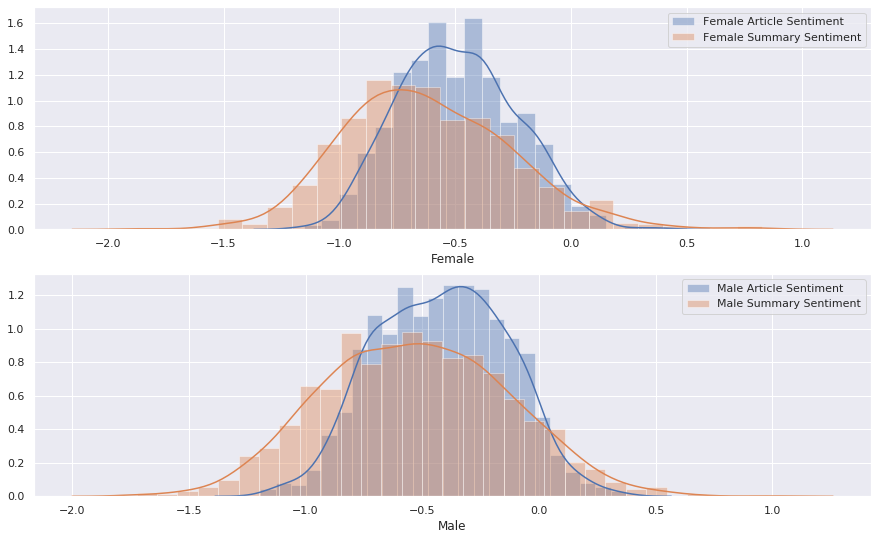

In [354]:
#comparing sentiment difference for female vs male articles

fem_only = bert_data.loc[bert_data['art_gender_coeff'] == 1.0]
masc_only = bert_data.loc[bert_data['art_gender_coeff'] == -1.0]


fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=False, figsize=(15,9))

seaborn.distplot(fem_only['article_sentiment'], label='Female Article Sentiment', ax=ax1)
seaborn.distplot(fem_only['summary_sentiment'], label='Female Summary Sentiment', ax=ax1)

seaborn.distplot(masc_only['article_sentiment'], label='Male Article Sentiment', ax=ax2)
seaborn.distplot(masc_only['summary_sentiment'], label='Male Summary Sentiment', ax=ax2)

ax1.set_xlabel('Female')
ax1.legend()

ax2.set_xlabel('Male')
ax2.legend()

ax1.get_ybound()

We'll do some tests to see if the change in sentiment score from summarization is the same between male- and female-subject articles. First, we examine the sentiment difference for article/summary pairs relative to the article sentiment score. If our models were perfect, we would see sentiment differences of 0 in a horizontal line across the range of article sentiments. 

What we actually see is a range, or band, of sentiment difference across the different article sentiment scores, for both genders, and it appears to be horizontal. The variance of these bands looks relatively steady across article sentiments.  These are good signs. They show that in general, although a summary sentiment's score is on average lower than its corresponding article's score, this change in score is relatively consistent for all types of article scores


Text(0.5, 0, 'Male')

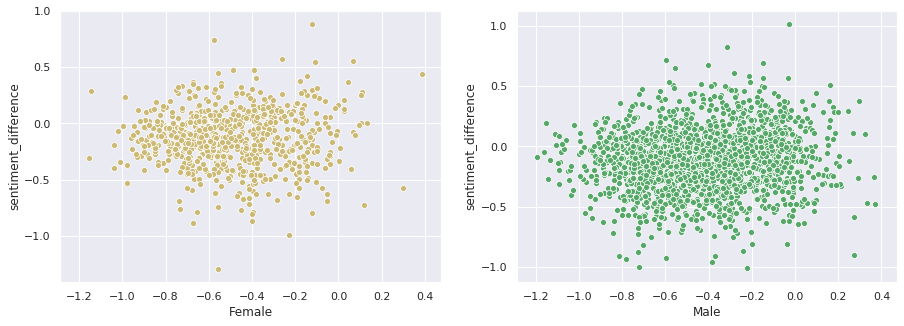

In [352]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(15,5))

seaborn.scatterplot(fem_only['article_sentiment'], fem_only['sentiment_difference'], color="y", ax=ax1)
seaborn.scatterplot(masc_only['article_sentiment'], masc_only['sentiment_difference'], color="g", ax=ax2)

ax1.set_xlabel('Female')
ax2.set_xlabel('Male')


Plotting the gendered sentiment change on a histogram shows how similar the sentiment change data are for female and male articles. However, it does appear that the distribution for male articles is ever so slightly shifted right.

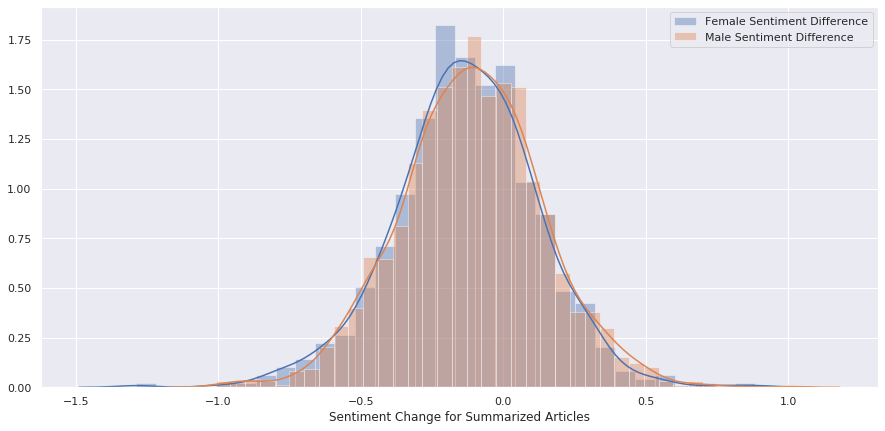

In [360]:
#compare sentiment difference scores for male and female articles
plt.subplots(figsize=(15,7))

seaborn.distplot(fem_only['sentiment_difference'], label='Female Sentiment Difference')
seaborn.distplot(masc_only['sentiment_difference'], label='Male Sentiment Difference')

plt.xlabel('Sentiment Change for Summarized Articles')
plt.legend()


To investigate, we run a regression of article sentiment on sentiment differences between inputs/outputs. 

The results show that for female-subject articles the change in sentiment from summarization does not change with article sentiment scores. For male-subject articles, an increase of 1.0 in the article sentiment yields a statistially significant ~0.1 increase in the sentiment score. That is, more positive articles get summaries that are slightly more positive than they should be.

In [339]:
masc_ols = statsmodels.formula.api.ols('sentiment_difference ~ article_sentiment', data=masc_only).fit()
fem_ols = statsmodels.formula.api.ols('sentiment_difference ~ article_sentiment', data=fem_only).fit()
print(masc_ols.summary().tables[1])
print(fem_ols.summary().tables[1])

                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0710      0.010     -6.765      0.000      -0.092      -0.050
article_sentiment     0.0963      0.021      4.598      0.000       0.055       0.137
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1177      0.021     -5.660      0.000      -0.159      -0.077
article_sentiment     0.0273      0.038      0.722      0.471      -0.047       0.102


A student's t-test shows that the average change in sentiment based on gender is borderline statistically significant. What if we look at the effect size?

In [378]:
# t-test
sent_diff_test = stats.ttest_ind(masc_only['sentiment_difference'], fem_only['sentiment_difference'])
print('t-statistic:', sent_diff_test[0])
print('p-value:', sent_diff_test[1])

t-statistic: 1.7799393126677139
p-value: 0.07520351605915117


To examine the effect size, we multiply the t-statistic by the pooled standard deviation.

In [382]:
# Finding effect size
# pooled standard deviation -- sqrt(SD1^2 + SD2^2 / N1 + N2 - 2)
masc_std = np.std(masc_only['sentiment_difference'])
fem_std = np.std(fem_only['sentiment_difference'])
masc_n = len(masc_only['sentiment_difference'])
fem_n = len(fem_only['sentiment_difference'])
pooled_std = np.sqrt( (masc_std**2 + fem_std**2)/(masc_n + fem_n -2) ) 

effect = sent_diff_test[0] * pooled_std
print("average difference in sentiment change is", effect, "in favor of male-subject articles")

average difference in sentiment change is 0.012486070528190313 in favor of male-subject articles


### Regression of sentiment difference on article sentiment, with dummy "male" as covariate

In [394]:
single_gender = pd.concat([fem_only, masc_only], ignore_index=True)
len(single_gender)

2583

In [405]:
#create a dummy variable for male (yes = 1, no = 0)
def is_male(gender_coeff):
    if gender_coeff == -1:
        return 1
    else:
        return 0
    
single_gender['is_male'] = single_gender['art_gender_coeff'].apply(is_male)

In [411]:
combined_ols_a = statsmodels.formula.api.ols('sentiment_difference ~ is_male', data=single_gender).fit()
print(combined_ols_a.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1311      0.010    -13.788      0.000      -0.150      -0.112
is_male        0.0198      0.011      1.780      0.075      -0.002       0.042
